In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import pickle

In [2]:
def ones_to_zeros(ET_inner_dict, ET_outer_dict):
    
    for k in range(0,len(ET_inner_dict)):
        for i in range(ET_inner_dict[k].shape[0]):
            equal_inner = np.array_equal(ET_inner_dict[k][i],np.ones_like(ET_inner_dict[k][i]))
            equal_outer = np.array_equal(ET_outer_dict[k][i],np.ones_like(ET_outer_dict[k][i]))
            if equal_inner or equal_outer:
                ET_inner_dict[k][i]=np.zeros_like(ET_inner_dict[k][i])
                ET_outer_dict[k][i]=np.zeros_like(ET_outer_dict[k][i])
                
    return ET_inner_dict, ET_outer_dict

In [3]:
def double_size(X_in):

    X_out = np.zeros(
        shape=(2*X_in.shape[0],2*X_in.shape[1],1),
        dtype=np.float32
    )
    
    for i in range(X_in.shape[0]):
        for j in range(X_in.shape[1]):
            
            if X_in[i,j]!=0:
                value = X_in[i,j]/4
                X_out[2*i,2*j]=value
                X_out[2*i+1,2*j]=value
                X_out[2*i,2*j+1]=value
                X_out[2*i+1,2*j+1]=value
    return X_out

In [4]:
def insert(X_inner, X_outer):
    X=X_outer
    
    for i in range(12,40):
        for j in range(16,48):
            X[i,j]=X_inner[i-12,j-16]
    
    return X

In [5]:
def generate_HCAL_images(ET_inner_dict, ET_outer_dict):
    
    output_pics = {}
    
    pic = np.array(np.zeros(shape=(52,64,1), dtype=np.float32))
    
    for j in range(len(ET_inner_dict)):
        
        
        output_pics[j]=np.array([pic for i in range(len(ET_inner_dict[j]))])    
        
    
    for j in range(len(ET_inner_dict)):
        
        for k in range(len(ET_inner_dict[j])):
            
            ET_image = insert(ET_inner_dict[j][k], double_size(ET_outer_dict[j][k]))
            ET_image = np.flip(ET_image, axis = 0)
            
            output_pics[j][k]= ET_image
            
        print('Done batch {0}'.format(j+1))
                
    return output_pics

In [6]:
ET_inner_dict={}
ET_outer_dict={}

i=0
while os.path.exists('/disk/lhcb_data/davide/HCAL_project_full_event/npy/B2Dmunu_full/ET_inner/batch_'+str(i)+'.npy'):
#while i < 2:
    ET_inner_dict[i]=np.load('/disk/lhcb_data/davide/HCAL_project_full_event/npy/B2Dmunu_full/ET_inner/batch_'+str(i)+'.npy')
    ET_outer_dict[i]=np.load('/disk/lhcb_data/davide/HCAL_project_full_event/npy/B2Dmunu_full/ET_outer/batch_'+str(i)+'.npy')

    i+=1
    

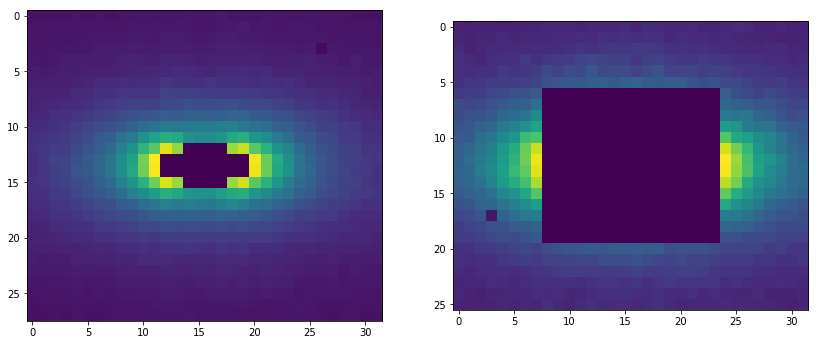

In [7]:
mean_inner_ET=np.mean(ET_inner_dict[0], axis=0, keepdims=True).reshape(32,32)
plt.subplot(1,2,1)
plt.imshow(mean_inner_ET[2:mean_inner_ET.shape[0]-2,0:mean_inner_ET.shape[0]])
plt.subplot(1,2,2)
mean_outer_ET=np.mean(ET_outer_dict[0], axis=0, keepdims=True).reshape(32,32)
plt.imshow(mean_outer_ET[3:mean_outer_ET.shape[0]-3,0:mean_outer_ET.shape[0]])
fig = plt.gcf()
fig.set_size_inches(14,6)

In [12]:
ET_inner_dict, ET_outer_dict = ones_to_zeros(ET_inner_dict, ET_outer_dict)

In [18]:
#cutting out useless pixels
for i in range(len(ET_inner_dict)):
    ET_inner_dict[i]=ET_inner_dict[i][:,2:ET_inner_dict[i].shape[1]-2,:]
    ET_outer_dict[i]=ET_outer_dict[i][:,3:ET_outer_dict[i].shape[1]-3,:]
    

In [19]:
#Check cut dict dimensions
print(ET_inner_dict[0].shape, ET_outer_dict[0].shape)
#is
#(?, 28, 32), (?,26, 32)

((20000, 28, 32), (20000, 26, 32))


In [20]:
def delete_undetected_events(X_inner, X_outer):

    pos_rejected={}
    
    for i in range(len(X_inner)):
        pos_rejected[i]=[]
        
        for j in range(X_inner[i].shape[0]):
            
            equal_inner = np.array_equal(X_inner[i][j],np.zeros_like(X_inner[i][j]))
            equal_outer = np.array_equal(X_outer[i][j],np.zeros_like(X_outer[i][j]))
            
                
    X_inner_filtered={}
    X_outer_filtered={}
    for i in range(len(X_inner)):
    
        X_inner_filtered[i]=np.delete(X_inner[i],pos_rejected[i],axis=0)
        X_outer_filtered[i]=np.delete(X_outer[i],pos_rejected[i],axis=0)
        
    return X_inner_filtered, X_outer_filtered

In [21]:

ET_inner_filtered, ET_outer_filtered = delete_undetected_events(ET_inner_dict,ET_outer_dict)


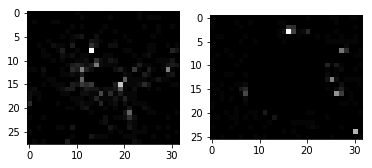

In [31]:
plt.subplot(1,2,1)
plt.imshow(ET_inner_filtered[0][2].reshape(28,32),cmap='gray')
plt.subplot(1,2,2)
plt.imshow(ET_outer_filtered[0][2].reshape(26,32),cmap='gray')

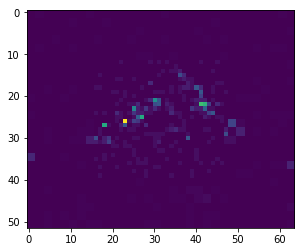

In [33]:

i=11
plt.imshow(np.flip(insert(ET_inner_filtered[0][i],double_size(ET_outer_filtered[0][i])).reshape(52,64),axis=0))



In [34]:
output_pics = generate_HCAL_images(ET_inner_filtered,ET_outer_filtered)

Done batch 1
Done batch 2
Done batch 3
Done batch 4
Done batch 5
Done batch 6
Done batch 7
Done batch 8
Done batch 9
Done batch 10
Done batch 11
Done batch 12


In [35]:
output_pics[0].shape

(20000, 52, 64, 1)

In [36]:
for i in range(len(output_pics)):
    with open('/disk/lhcb_data/davide/HCAL_project_full_event/reco/sample'+str(i)+'.pickle', 'wb') as handle:
        pickle.dump(output_pics[i], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [37]:
a=np.array([output_pics[0][i].sum() for i in range(len(output_pics[0]))])

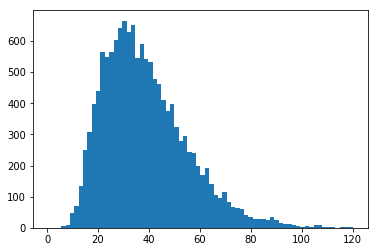

In [41]:
plt.hist(a/1000,range=(0.5,120),bins=70);